# Tridiagonal models for DBM


## 1. Static

In [1]:
%pylab inline
from matplotlib import gridspec
plt.style.use('classic')
plt.rc('figure',facecolor='w')
plt.rc('font', size=10)
from numpy.matlib import repmat
from scipy.stats import chi
import plotly.graph_objs as go
import plotly.offline
import sys
sys.path.append('../dyson_brownian_motion/')
from plot_tools import adjust_spines, sc_law, plot_dpp, plot_traj_with_histo, plot_traj_with_histo_sclaw


Populating the interactive namespace from numpy and matplotlib


In [2]:
def tridiagonal_model_gaussian(dim, beta):
    diag = (1/np.sqrt(dim))*np.diag(np.random.randn(dim))
    u_diag_vect = np.zeros(dim-1)
    for i in range(0,dim-1):
        #u_diag_vect[i] = np.sqrt(np.random.chisquare((dim-(i+1))*beta))
        u_diag_vect[i] = np.linalg.norm( (1/np.sqrt(2*dim))*np.random.randn((dim-(i+1))*beta) )
    u_diag = np.diag(u_diag_vect,1)
    H_b = diag + u_diag + u_diag.T
    return H_b

In [3]:
# Eigenvalues sample
N = 200
eigenvalues_samples = np.linalg.eigvalsh(tridiagonal_model_gaussian(N, 2))

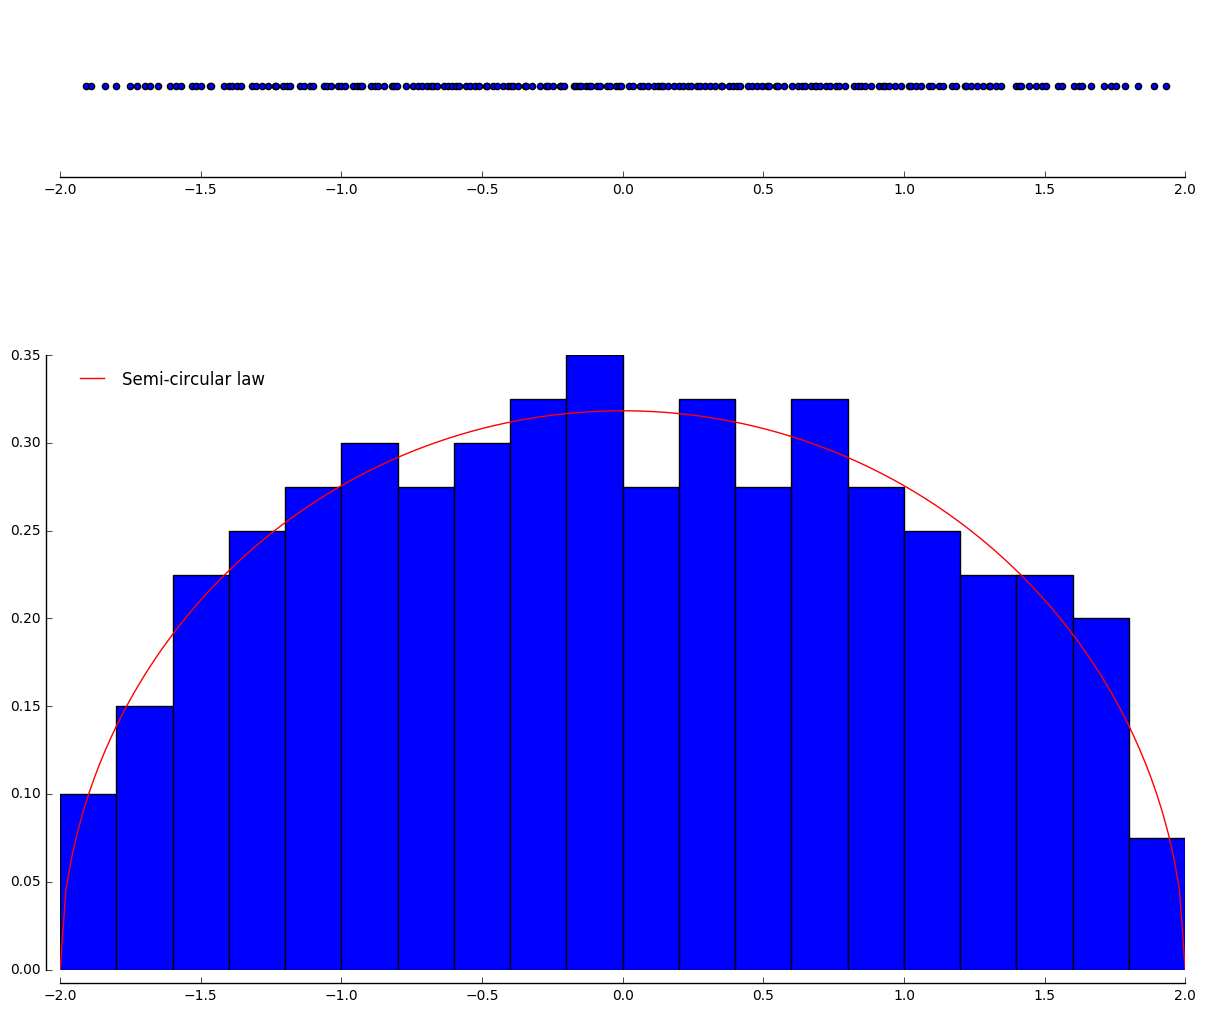

In [4]:
plot_dpp(eigenvalues_samples, './plot/tridiag_gue_eigenvalues.png')

## 2. Dynamic (classic)

In [5]:
class naive_brownian_bessel_tridiag_model:
    def __init__(self, n_traj, n_samples, tf, beta, rescaling=False):
        self.n_traj = n_traj
        self.n_samples = n_samples
        self.tf = tf
        self.dt = tf/n_samples
        self.beta = beta
        self.brownians_list = [ [np.zeros(i*self.beta) for i in range(1, self.n_traj)] ]
        self.diag_list = [ np.zeros(self.n_traj) ]
        self.tridiag_matrices_list = [np.zeros((self.n_traj, self.n_traj))]
        self.generate()
        self.eigen_values = np.zeros((self.n_samples+1, self.n_traj))
        self.diag(rescaling)

    def generate(self):
        for sample in range(self.n_samples+1):
            
            diag = self.diag_list[sample] + np.random.randn(self.n_traj)*(self.dt/self.n_traj)**0.5
            self.diag_list.append( diag )
            
            tridiag_matrix = np.diag( diag )
            brownians_sample_list = []
            
            for i in range(1, self.n_traj):
                brownians_sample = self.brownians_list[sample][i-1] + np.random.randn(i*self.beta)*(self.dt/(2*self.n_traj))**0.5
                brownians_sample_list.append( brownians_sample )
                
                tridiag_matrix[(self.n_traj-1)-i, (self.n_traj)-i] = np.sqrt( np.sum( brownians_sample**2 ))
                tridiag_matrix[(self.n_traj)-i, (self.n_traj-1)-i] = np.sqrt( np.sum( brownians_sample**2 ))
            
            self.brownians_list.append(brownians_sample_list)
            self.tridiag_matrices_list.append(tridiag_matrix)

    def diag(self, rescaling):
        if rescaling:
            for sample in range(1, self.n_samples+1):
                eigen_values = sorted(np.real( np.linalg.eigvalsh(self.tridiag_matrices_list[sample]) ), reverse=True)
                self.eigen_values[sample] = np.multiply(eigen_values, 1/np.sqrt((sample)*self.dt))
                #print(1/np.sqrt((sample+1)*self.dt))
        else:
            for sample in range(1, self.n_samples+1):
                self.eigen_values[sample] = \
                    sorted(np.real(np.linalg.eigvalsh(self.tridiag_matrices_list[sample])), reverse=True)

In [6]:
test_n_bb_model = naive_brownian_bessel_tridiag_model(50, 300, 1, beta=2, rescaling=False)

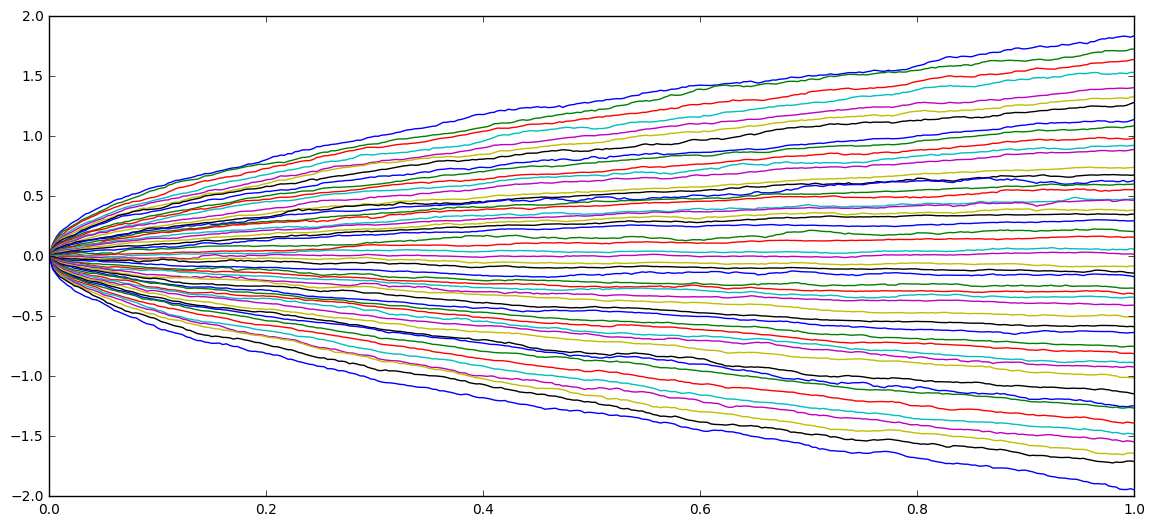

In [7]:
#plot_traj_with_histo_sclaw(naive_brownian_bessel_tridiag_model, R=2, title='./plot/tridiag_dyn.png.png')
fig = plt.figure(1, figsize=(14, 6))
t = np.matlib.repmat(np.arange(0, test_n_bb_model.tf+test_n_bb_model.dt, test_n_bb_model.dt), test_n_bb_model.n_traj,1)
plt.plot(t.T, test_n_bb_model.eigen_values)
plt.savefig('./plot/tridiag_dyn.png', bbox_inches='tight')

## 2. Dynamic (rescale)

In [28]:
test_beta_hermite_dpp_rescale = naive_brownian_bessel_tridiag_model(100, 300, 1, beta=2, rescaling=True)

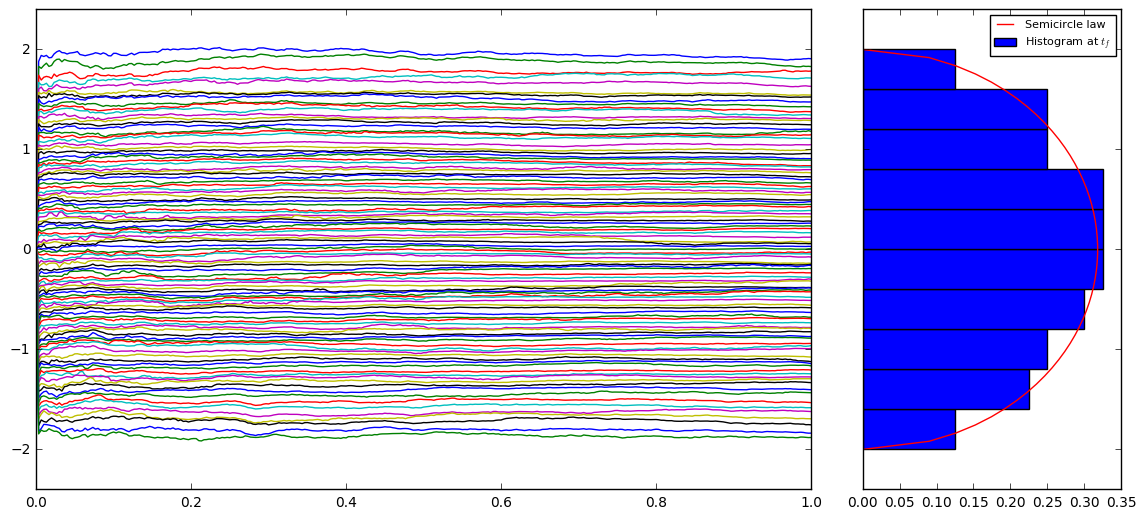

In [31]:
plot_traj_with_histo_sclaw(naive_brownian_bessel_tridiag_model,2, './plot/beta_dbm_rescale_histo.png')

## Nouvelle tentative suite rdv 30/08

In [18]:
def gue(dim, beta, normalization=False):
    """ GUE matrix used to generated the Hermitian Brownian motion as describe in agz
            parameters :
                - beta=1 for GOE et 2 for GUE
                - normalization=True if division by 1/sqrt(N) is wanted (in agz for example)
            """
    B = np.random.randn(dim, dim)
    B_tild = np.random.randn(dim, dim)
    diag = (2/(beta))**0.5 * np.diag(np.diag(B))
    triu = (1/(beta))**0.5 * (np.triu(B,1) + 1j*(beta-1)*np.triu(B_tild,1))
    H = np.zeros((dim,dim)) + diag + triu + np.conjugate(triu).T
    if normalization:
        H_return = (1/(dim**0.5))*H
    else:
        H_return = H
    return H_return

In [20]:
N=200
eigenvalues_samples = np.linalg.eigvalsh(gue(N, 2, normalization=True))

#plot_dpp(eigenvalues_samples, './plot/gue_eigenvalues.png')

In [105]:
SEED = 32
np.random.seed(SEED)
dim=4
A = gue(dim, 2, normalization=True)
A

array([[-0.17444723+0.j        ,  0.34779168+0.12414385j,
         0.20538724-0.03144264j,  0.02484930+0.32419228j],
       [ 0.34779168-0.12414385j,  0.29097937+0.j        ,
         0.52035653+0.13758564j,  0.58802328-0.15024692j],
       [ 0.20538724+0.03144264j,  0.52035653-0.13758564j,
        -0.34746163+0.j        ,  0.68604329-0.31405623j],
       [ 0.02484930-0.32419228j,  0.58802328+0.15024692j,
         0.68604329+0.31405623j,  0.05709025+0.j        ]])

In [127]:
H=np.zeros((dim-1,dim-1))+1j*np.zeros((dim-1,dim-1))
H[0,:]=A[1:,0]/np.linalg.norm(A[1:,0],2)

In [128]:
H

array([[ 0.65117492-0.23243616j,  0.38454921+0.05887047j,
         0.04652567-0.60698944j],
       [ 0.00000000+0.j        ,  0.00000000+0.j        ,  0.00000000+0.j        ],
       [ 0.00000000+0.j        ,  0.00000000+0.j        ,  0.00000000+0.j        ]])

In [129]:
np.dot(np.dot(H,A), np.conjugate(H).T)

ValueError: shapes (3,3) and (4,4) not aligned: 3 (dim 1) != 4 (dim 0)

In [118]:
np.dot(H,np.conjugate(H).T)

array([[ 1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j]])

In [121]:
from scipy.linalg import sqrtm, inv
def sym(w):
    return w.dot(inv(sqrtm(w.T.dot(w))))

In [124]:
test=sym(H)

In [126]:
np.dot(test,np.conjugate(test).T)

array([[ 2.88087112+0.j,  0.00000000+0.j,  0.00000000+0.j],
       [ 0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j],
       [ 0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j]])

In [130]:
A

array([[-0.17444723+0.j        ,  0.34779168+0.12414385j,
         0.20538724-0.03144264j,  0.02484930+0.32419228j],
       [ 0.34779168-0.12414385j,  0.29097937+0.j        ,
         0.52035653+0.13758564j,  0.58802328-0.15024692j],
       [ 0.20538724+0.03144264j,  0.52035653-0.13758564j,
        -0.34746163+0.j        ,  0.68604329-0.31405623j],
       [ 0.02484930-0.32419228j,  0.58802328+0.15024692j,
         0.68604329+0.31405623j,  0.05709025+0.j        ]])

In [138]:
A = gue(6, 2, normalization=True)
np.linalg.eigvalsh(np.dot(A,np.conjugate(A).T))

array([ 0.07381693,  0.12908037,  1.20953363,  1.32327853,  2.55316049,
        2.67408724])

In [5]:
for ind, val in enumerate([0,9,8]):
    print(ind,val)

0 0
1 9
2 8
